# KNN

In [25]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,f1_score

#Set figure size
sns.set(rc={'figure.figsize':(5,5)})

#Load data
df = pd.read_csv(os.path.join('data','data_filtered.csv'))
df2 = pd.read_csv(os.path.join('data','data_all.csv'))

#Enable CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

df

,sd,Q25,IQR,sp.ent,sfm,meanfun,mindom,dfrange,label
0,0.241585,0.455971,-0.601712,0.796058,0.925288,1.302489,-0.708404,-0.415794,1
1,-0.114476,-0.105393,0.401743,0.461699,-0.229014,-0.259737,-0.461523,0.412186,0
2,-1.284107,1.726540,-1.169425,-1.599113,-1.269425,1.315527,-0.461523,1.777355,1
3,1.089943,-0.391539,0.786946,0.578250,0.982092,-0.698228,-0.708404,-0.679948,0
4,0.231523,0.681061,-0.527833,0.508050,0.516462,1.167348,-0.708404,-1.343664,1
...,...,...,...,...,...,...,...,...,...
3163,1.087355,-0.480803,0.982768,1.385949,1.667369,-0.969765,-0.338082,-1.208257,0
3164,-1.471392,0.863030,-1.176833,-0.555301,-1.128432,0.530223,1.143207,-1.214917,1
3165,0.644400,-0.395149,0.953317,0.626947,0.305185,-0.983770,-0.708404,-0.688828,0
3166,1.557415,-0.558784,0.970942,1.076622,1.232644,-0.441604,-0.708404,-0.005133,0


In [2]:
feature_size = len(df.drop(['label'],axis=1).columns)
print(f'Number of Features: {feature_size}')

train_x, test_x, train_y, test_y = train_test_split(
    df.drop(['label'], axis=1), df['label'], test_size=0.2, random_state=42)


Number of Features: 8


In [26]:
def run(algorithm: str = 'auto',  #Algorithm used to compute the nearest neighbors [‘ball_tree’, ‘kd_tree’, ‘brute’]
        p:int = 2, # Power parameter for the Minkowski metric. p=2 is Euclidian Distance
        weights: str = 'unifrom', # Weight function used in prediction. [‘uniform’, ‘distance’]
        n_neighbors:int = 2, # Number of Neighbours
        show: bool = True):
    kmeans = KNeighborsClassifier(n_neighbors=n_neighbors, 
                                  algorithm=algorithm, p=p).fit(train_x, train_y)
    
    prediction = kmeans.predict(test_x)
    
    accuracy = accuracy_score(prediction, test_y)
    precision = precision_score(prediction, test_y)
    recall = recall_score(prediction, test_y)
    f1 = f1_score(prediction, test_y)
    
    if not show:
        return [accuracy, precision, recall, f1]
    
    #Generate confusion matrix
    cm = confusion_matrix(test_y, prediction)
    count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
    percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
    labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
              zip(count,percentage)]).reshape(2,2)
    sns.heatmap(cm,fmt='',annot=labels)
    
    # Print to standard output
    print('Accuracy:\t%.3f' % accuracy)
    print('Precision:\t%.3f' % precision)
    print('Recall:  \t%.3f' % recall)
    print('F1 Score:\t%.3f' % f1)
    
    return [accuracy,precision,recall,f1]

# Evaluation

## Which value for k produces the best results?

In [37]:
data = []
for k in range(1,12):
    a,p,r,f = run(n_neighbors=k, show=False)
    
    #Tally metrics
    data.append([k,a,p,r,f])

metrics_df = pd.DataFrame(data,columns=['k','Accuracy','Prediction','Recall','F1 Score'])

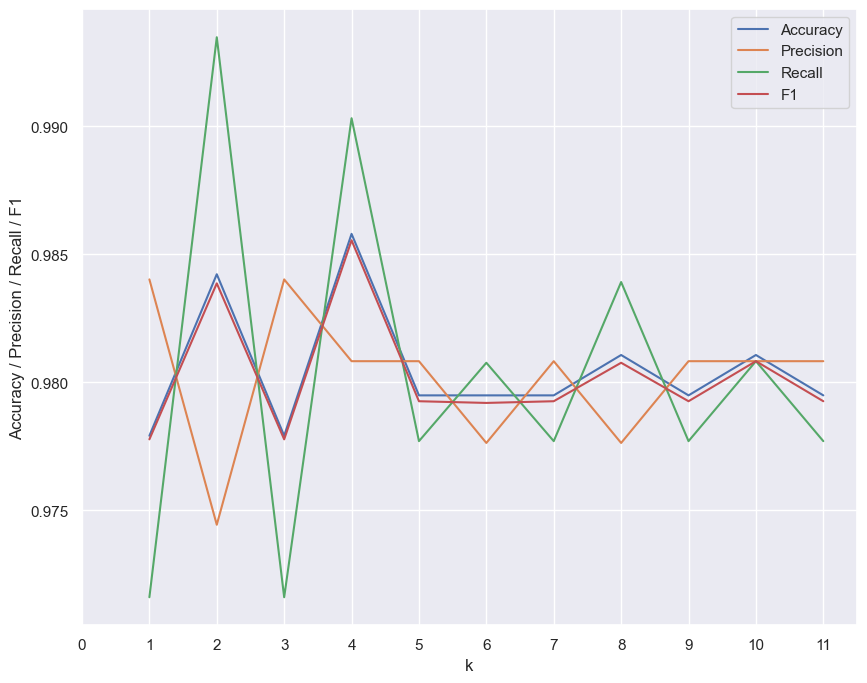

In [38]:
sns.set(rc={'figure.figsize':(10,8)})
fig,ax = plt.subplots(1,1)

sns.lineplot(data=metrics_df, x='k',y='Accuracy', ax=ax)
sns.lineplot(data=metrics_df, x='k',y='Prediction', ax=ax)
sns.lineplot(data=metrics_df, x='k',y='Recall', ax=ax)
sns.lineplot(data=metrics_df, x='k',y='F1 Score', ax=ax)


ax.set_xticks(range(0,12))

ax.set_ylabel("Accuracy / Precision / Recall / F1")
ax.legend(["Accuracy","Precision","Recall","F1"])

plt.show()

## Algorithm to compute nearest neighbors.

Accuracy:	0.984
Precision:	0.974
Recall:  	0.993
F1 Score:	0.984


[0.9842271293375394, 0.9744408945686901, 0.993485342019544, 0.9838709677419355]

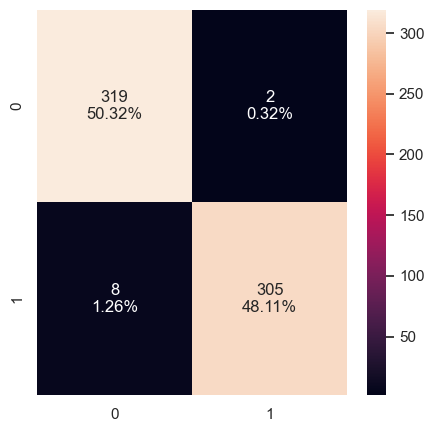

In [28]:
run(algorithm='ball_tree')

Accuracy:	0.984
Precision:	0.974
Recall:  	0.993
F1 Score:	0.984


[0.9842271293375394, 0.9744408945686901, 0.993485342019544, 0.9838709677419355]

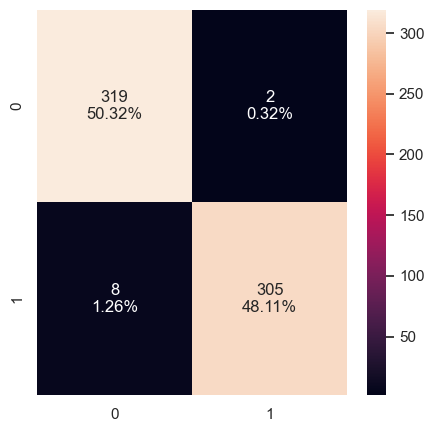

In [29]:
run(algorithm='kd_tree')

Accuracy:	0.984
Precision:	0.974
Recall:  	0.993
F1 Score:	0.984


[0.9842271293375394, 0.9744408945686901, 0.993485342019544, 0.9838709677419355]

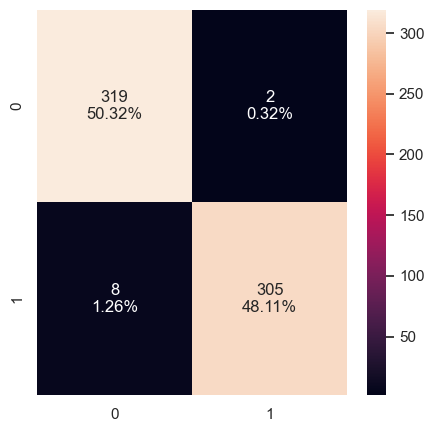

In [18]:
run(algorithm='brute')

All algorithm converge to the same values.

## Varying the parameter <code>p</code>

In [19]:
data = []
for p in range(1,8):
    a,prec,r,f = run(p=p, show=False, n_neighbors=2)
    
    #Tally metrics
    data.append([p,a,prec,r,f])

metrics_df = pd.DataFrame(data,columns=['p','Accuracy','Prediction','Recall','F1 Score'])

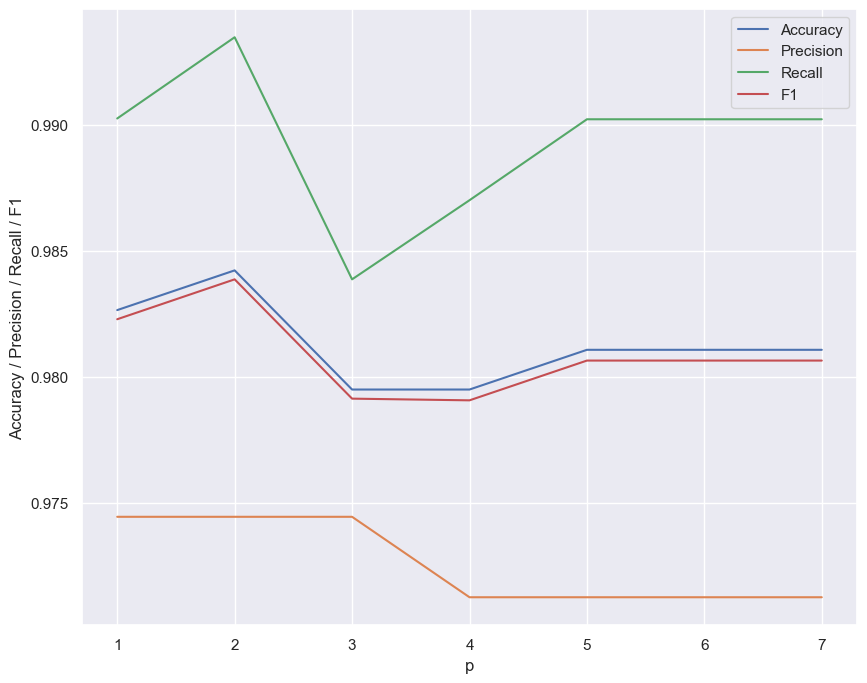

In [20]:
sns.set(rc={'figure.figsize':(10,8)})
fig,ax = plt.subplots(1,1)

sns.lineplot(data=metrics_df, x='p',y='Accuracy', ax=ax)
sns.lineplot(data=metrics_df, x='p',y='Prediction', ax=ax)
sns.lineplot(data=metrics_df, x='p',y='Recall', ax=ax)
sns.lineplot(data=metrics_df, x='p',y='F1 Score', ax=ax)

ax.set_ylabel("Accuracy / Precision / Recall / F1")
ax.legend(["Accuracy","Precision","Recall","F1"])

plt.show()

When <code>p=2</code> (or using Euclidean Distance) the model performs the best. 

## Varying the weight function
<ul>
<li>‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.</li>

<li>‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.</li>
</ul>

Accuracy:	0.984
Precision:	0.974
Recall:  	0.993
F1 Score:	0.984


[0.9842271293375394, 0.9744408945686901, 0.993485342019544, 0.9838709677419355]

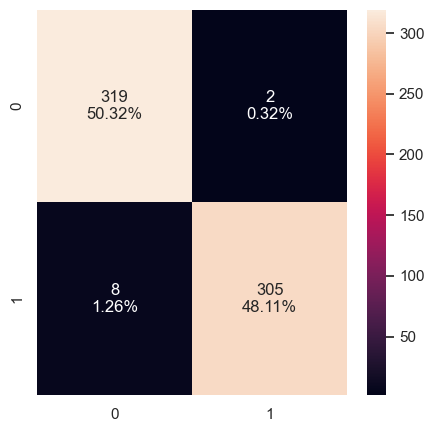

In [30]:
run(weights='uniform')

Accuracy:	0.984
Precision:	0.974
Recall:  	0.993
F1 Score:	0.984


[0.9842271293375394, 0.9744408945686901, 0.993485342019544, 0.9838709677419355]

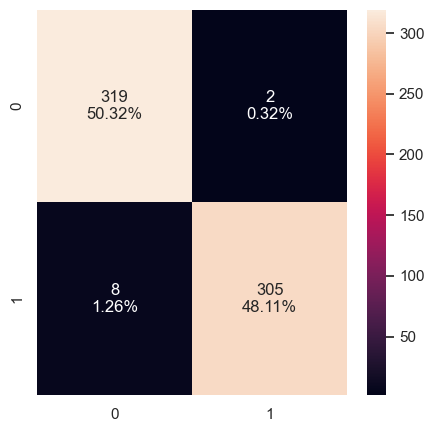

In [31]:
run(weights='distance')

It doesn't matter what weight function is used.

# Conclusion
KNN provides consistently good results (~98% accuracy). However varying the hyperparameters from the default values do not further improve the performance.